# GBNRTC Example Model

In [1]:
import emat
emat.__version__

'0.1.1'

In [2]:
import pandas, numpy, os, plotly_nb

In [3]:
from emat.util.loggers import log_to_stderr
log = log_to_stderr(level=20)

In [4]:
scope = emat.Scope('gbnrtc_scope.yaml')

In [5]:
db = emat.SQLiteDB('gbnrtc_1.sqlitedb', True)

[00:04.74] MainProcess/INFO: running script scope.sql
[00:04.75] MainProcess/INFO: running script exp_design.sql
[00:04.76] MainProcess/INFO: running script meta_model.sql


In [6]:
scope.store_scope(db)

The basic operation of the GBNRTC model can be controlled by EMAT through a custom developed 
class, which defines the input and output "hooks" that are consistent with the defined 
scope file.  The `GBNRTCModel` class is able to call to TransCAD, setup the input parameters
(exogenous uncertainties, policy levers, and constants defined in the scope), exceute the 
model, and retrieve the performance measure results.  

In [7]:
from emat.model import GBNRTCModel

In [8]:
g = GBNRTCModel(
    configuration='gbnrtc_model_config.yaml',
    scope=scope,
    db=db,
)
g

The GBNRTC model takes a couple of hours for each run, and runs in TransCAD, which 
is a proprietary software package that is not included with the EMAT distribution.
However, for demonstration purposes, the definition and results of a particular set 
of experiments is included in the file `buffalo.csv`.  We can use 
the `write_experiment_all` method to pre-load these results into the database.

In [9]:
lhs = pandas.read_csv('buffalo.csv')

db.write_experiment_all(
    'GBNRTC', 
    'lhs', 
    emat.SOURCE_IS_CORE_MODEL, 
    lhs,
)

In [10]:
len(g.read_experiments('lhs'))

60

In [11]:
len(g.read_experiments('lhs', only_pending=True))

0

The example data contains a large variety of output performance measures, as 
TransCAD models can potentially output a lot of data.

In [12]:
g.scope.get_measure_names()

['Region-wide VMT',
 'Interstate + Expressway + Ramp/Connector VMT',
 'Major and Minor Arterials VMT',
 'Total Auto VMT',
 'Total Truck VMT',
 'AM Trip Time (minutes)',
 'AM Trip Length (miles)',
 'PM Trip Time (minutes)',
 'PM Trip Length (miles)',
 'Total Transit Boardings',
 'Total LRT Boardings',
 'Downtown to Airport Travel Time',
 'Households within 30 min of CBD',
 'Number of Home-based work tours taking <= 45 minutes via transit',
 'Corridor Kensington Daily VMT',
 'Corridor Kensington Daily VHT',
 'Corridor Kensington_OB PM VMT',
 'Corridor Kensington_OB PM VHT',
 'Corridor Kensington_IB AM VMT',
 'Corridor Kensington_IB AM VHT',
 'Corridor 190 Daily VMT',
 'Corridor 190 Daily VHT',
 'Corridor 190_OB Daily VMT',
 'Corridor 190_OB Daily VHT',
 'Corridor 190_IB Daily VMT',
 'Corridor 190_IB Daily VHT',
 'Corridor 33_west Daily VMT',
 'Corridor 33_west Daily VHT',
 'Corridor I90_south Daily VMT',
 'Corridor I90_south Daily VHT',
 'OD Volume District 1 to 1',
 'OD Volume District 

The high level scope
definition is designed to capture all of this data for later analysis, but
in this demonstration we will only evaluate a few of these performance measures.
In part, this is because creating meta-models for each performance measure is 
relatively inexpensive (computationally speaking) but not free -- it can take 
a few seconds to create the meta-model and it is not needed here if we are not 
interested in all these results for this analysis.

Creating a meta-model for analysis of an existing model with a completed 
design of experiments can be done using the `create_metamodel_from_design` 
method. To create a meta-model on a more limited scope, we can use the 
`include_measures` argument to list out a subset of measures that will be
included in this metamodel.

In [13]:
mm = g.create_metamodel_from_design(
    'lhs',
    include_measures=[
        'Region-wide VMT', 
        'AM Trip Length (miles)',
        'AM Trip Time (minutes)',
        'Downtown to Airport Travel Time',
        'Total Transit Boardings',
        'Total LRT Boardings',
        'Peak Transit Share', 
        'Peak NonMotorized Share',
        'Corridor Kensington Daily VMT',
        'Corridor 190 Daily VMT',
        'Corridor 33_west Daily VMT',
        'Corridor I90_south Daily VMT',
    ]
)
mm

<emat.PythonCoreModel "GBNRTCMeta", metamodel_id=1 with 4 uncertainties, 2 levers, 46 measures>

You might notice that the class of the meta-model is no longer a `GBNRTCModel`
but instead now it is a `PythonCoreModel`.  This is because at its heart, the
meta-model is a Python function that wraps the gaussian process regression that
has been fit to the available experimental data.  Also, although the scope still
has 46 measures, only 10 are active in the actual meta-model:

In [14]:
mm.function

<emat.MetaModel 6 inputs -> 12 active and 46 total outputs>

In [15]:
callable(mm.function)

True

In [16]:
mm.function.regression

DetrendedMultipleTargetRegression(copy_X_train=True, n_restarts_optimizer=250,
                 random_state=None, standardize_before_fit=True)

In [17]:
mm.function.regression.lr.r2

Region-wide VMT                    0.996544
AM Trip Length (miles)             0.976859
AM Trip Time (minutes)             0.969360
Downtown to Airport Travel Time    0.950714
Total Transit Boardings            0.968683
Total LRT Boardings                0.975097
Peak Transit Share                 0.968484
Peak NonMotorized Share            0.972930
Corridor Kensington Daily VMT      0.981173
Corridor 190 Daily VMT             0.992054
Corridor 33_west Daily VMT         0.985759
Corridor I90_south Daily VMT       0.992192
dtype: float64

In [18]:
mm.function.regression.lr.coefficients_summary()

Coefficient  \
Region-wide VMT                 Land Use - CBD Focus             0.716566   
                                Freeway Capacity                 0.016095   
                                Auto IVTT Sensitivity           -0.087768   
                                Shared Mobility                  0.056346   
                                Kensington Decommissioning      -0.002179   
                                LRT Extension                   -0.003719   
                                _Intercept_                     16.316399   
AM Trip Length (miles)          Land Use - CBD Focus            -0.534515   
                                Freeway Capacity                 0.114825   
                                Auto IVTT Sensitivity           -0.283925   
                                Shared Mobility                 -0.232975   
                                Kensington Decommissioning       0.002865   
                                LRT Extension                    0.004985   
                                _Intercept_                      8.379185   
AM Trip Time (minutes)          Land Use - CBD Focus             2.939874   
                                Freeway Capacity                -0.528067   
                                Auto IVTT Sensitivity           -0.909405   
                                Shared Mobility                 -0.102624   
                                Kensington Decommissioning       0.081597   
                                LRT Extension                    0.028198   
                                _Intercept_                     13.309391   
Downtown to Airport Travel Time Land Use - CBD Focus             2.900882   
                                Freeway Capacity                -1.425318   
                                Auto IVTT Sensitivity           -0.553525   
                                Shared Mobility                  0.352107   
                                Kensington Decommissioning       0.123789   
                                LRT Extension                    0.028628   
                                _Intercept_                     13.656606   
Total Transit Boardings         Land Use - CBD Focus        225493.420307   
                                Freeway Capacity             -5901.126792   
...                                                                   ...   
Peak NonMotorized Share         LRT Extension                    0.000080   
                                _Intercept_                      0.038900   
Corridor Kensington Daily VMT   Land Use - CBD Focus        110929.242924   
                                Freeway Capacity              2427.446365   
                                Auto IVTT Sensitivity        -9260.993434   
                                Shared Mobility              25692.553139   
                                Kensington Decommissioning -137014.111952   
                                LRT Extension                  425.591391   
                                _Intercept_                  77795.409506   
Corridor 190 Daily VMT          Land Use - CBD Focus        336782.802497   
                                Freeway Capacity             21272.577215   
                                Auto IVTT Sensitivity       -32592.635079   
                                Shared Mobility              34596.026642   
                                Kensington Decommissioning   15161.403873   
                                LRT Extension                -1601.051573   
                                _Intercept_                 -89750.841997   
Corridor 33_west Daily VMT      Land Use - CBD Focus         38630.401753   
                                Freeway Capacity              5073.257366   
                                Auto IVTT Sensitivity        -3125.109722   
                                Shared Mobility               3853.244391   
                                Kensington Decommissioning

In [19]:
mm.function.cross_val_scores()

Region-wide VMT                    0.995566
AM Trip Length (miles)             0.987558
AM Trip Time (minutes)             0.963736
Downtown to Airport Travel Time    0.947686
Total Transit Boardings            0.989703
Total LRT Boardings                0.979908
Peak Transit Share                 0.993723
Peak NonMotorized Share            0.994833
Corridor Kensington Daily VMT      0.999051
Corridor 190 Daily VMT             0.991027
Corridor 33_west Daily VMT         0.983498
Corridor I90_south Daily VMT       0.991645
dtype: float64

Cross-validation scores are also available for just the gaussian process regression (GPR)
component of the meta-model.  These scores give an indication of the marginal additional
predictive value of using the GPR, over and above using just the ordinary least squares 
linear regression model used to detrend the data.

In [20]:
mm.function.cross_val_scores(gpr_only=True)

Region-wide VMT                    0.168329
AM Trip Length (miles)             0.623984
AM Trip Time (minutes)             0.319848
Downtown to Airport Travel Time    0.474701
Total Transit Boardings            0.791699
Total LRT Boardings                0.561264
Peak Transit Share                 0.846996
Peak NonMotorized Share            0.845914
Corridor Kensington Daily VMT      0.944131
Corridor 190 Daily VMT             0.467828
Corridor 33_west Daily VMT         0.195671
Corridor I90_south Daily VMT       0.349282
dtype: float64

To use the metamodel for exploratory analysis, we can design and run a large
number of experiments.  Running the original GBNRTC model in TransCAD over 
10,000 iterations would take years (parallel processing notwithstanding) but 
running the meta-model over 10,000 iterations takes only a few moments. 

In [21]:
design = mm.design_experiments(n_samples=10000, sampler='lhs')

The meta-model evaluates pretty quickly, but not instantaneously.  To speed up the 
evaluation for this large number of experiments, we can parallelize the execution
by using a `DistributedEvaluator`.

In [22]:
from dask.distributed import Client, LocalCluster
from ema_workbench import DistributedEvaluator

cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
eval_dask = DistributedEvaluator(mm, client=client)

In [23]:
with eval_dask:
    result = mm.run_experiments(design, evaluator=eval_dask)

If we inspect the results, we see that among the performance measures, only the 
active measures have non-null computed values:

In [24]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 61 to 10060
Data columns (total 52 columns):
Land Use - CBD Focus                                                10000 non-null float64
Freeway Capacity                                                    10000 non-null float64
Auto IVTT Sensitivity                                               10000 non-null float64
Shared Mobility                                                     10000 non-null float64
Kensington Decommissioning                                          10000 non-null bool
LRT Extension                                                       10000 non-null bool
Region-wide VMT                                                     10000 non-null float64
Interstate + Expressway + Ramp/Connector VMT                        0 non-null float64
Major and Minor Arterials VMT                                       0 non-null float64
Total Auto VMT                                                      0 non-null float6

Although only the active performance measures have non-null computed values, all of the 
original performace measures in the scope are included in the resulting dataframe. 

The results of these meta-model experiments can be used for visualization and
other exploratory modeling applications.

<xmle.Elem 'img' with 0 children>
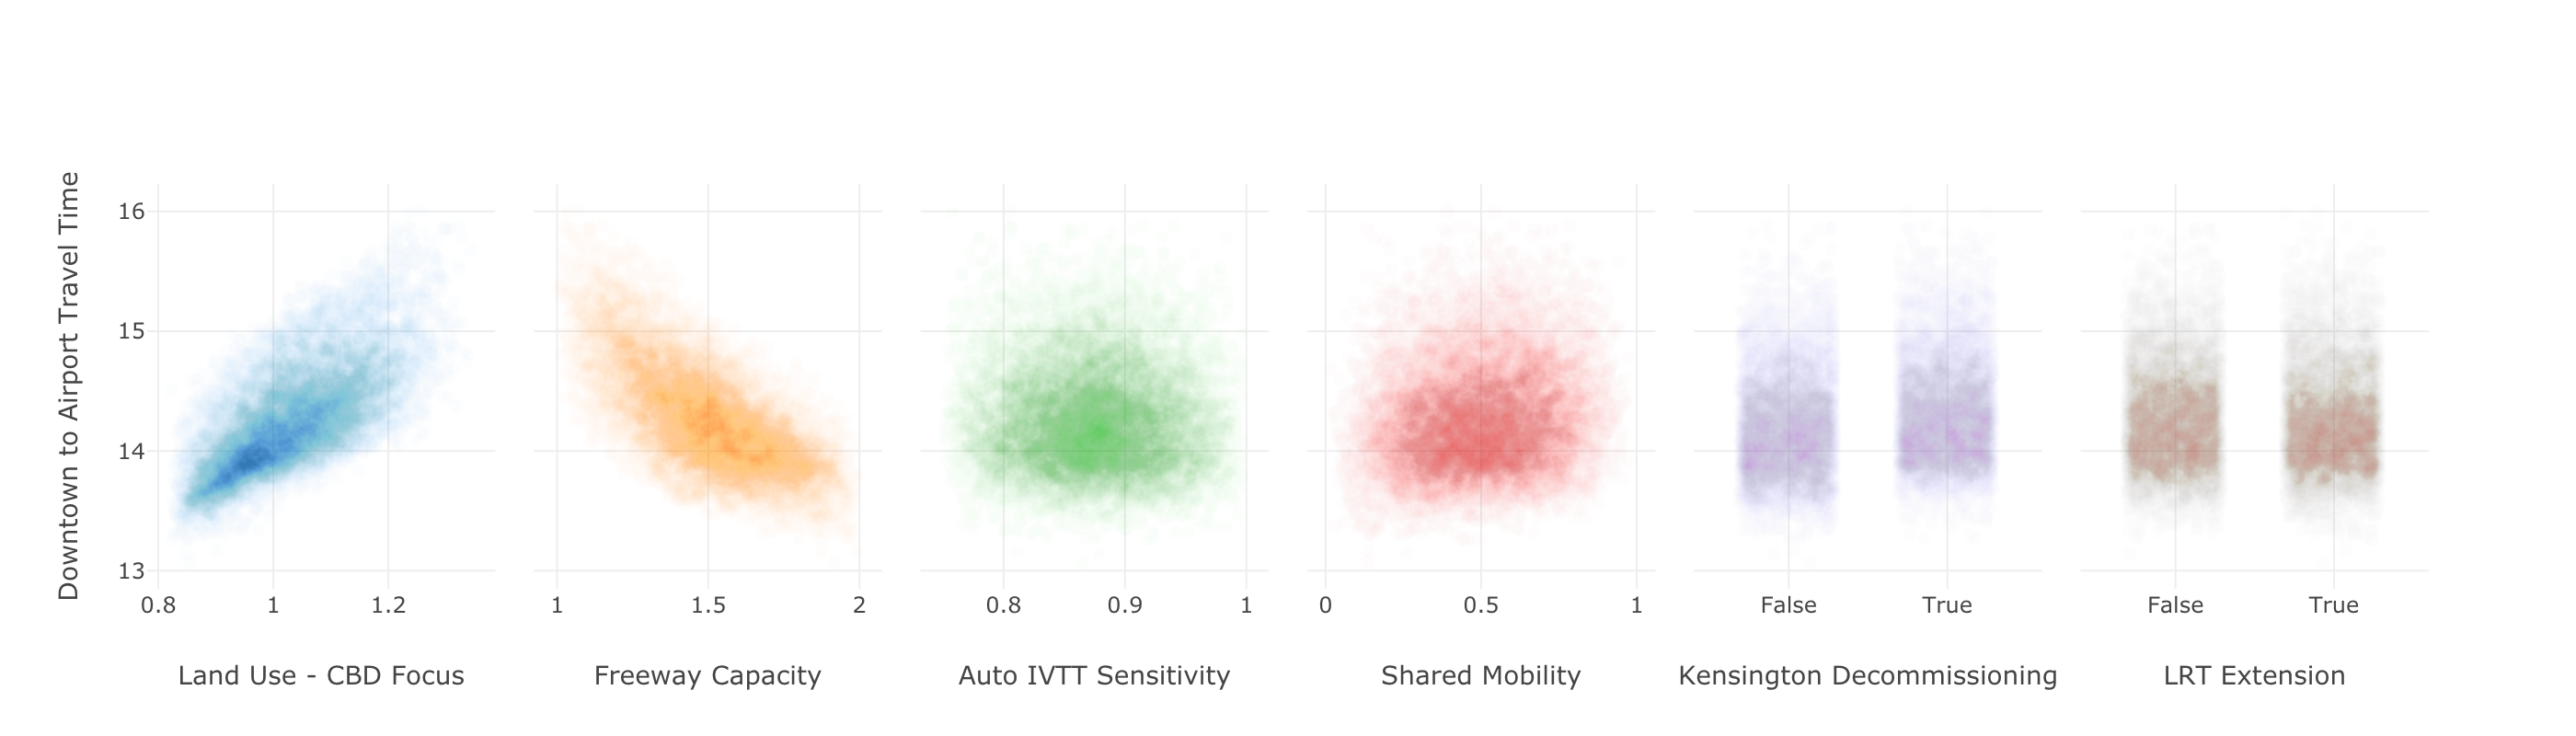

In [25]:
from emat.viz import scatter_graphs
scatter_graphs('Downtown to Airport Travel Time', result, scope=mm.scope, render='png')

In [26]:
from emat.interactive import Explorer
explorer = Explorer('db')

In [41]:
from emat import Box, Boxes

interesting_features = {
    'Shared Mobility',
    'Region-wide VMT',
    'AM Trip Time (minutes)',
    'AM Trip Length (miles)',
    'Total Transit Boardings',
    'Total LRT Boardings',
    'Peak Transit Share',
    'Downtown to Airport Travel Time',
    'Corridor Kensington Daily VMT',
}

In [42]:
# Columns that will be invalid in Explorer
[
    i 
    for i in interesting_performance_measures 
    if (i not in result.columns[~result.isna().all()] )
]

[]

In [43]:
boxes = Boxes(
    Box('Kensington Off & Low Pop',
        allowed={'Kensington Decommissioning':[False]},
        upper_bounds={'Land Use - CBD Focus':1.1},
        relevant=interesting_performance_measures),
    Box('LRT Strategy Off',
        parent='Kensington Off & Low Pop',
        allowed={'LRT Extension':[False]}),
    Box('LRT Strategy On',
        parent='Kensington Off & Low Pop',
        allowed={'LRT Extension': [True]}),
    Box('High Population Growth',
        lower_bounds={'Land Use - CBD Focus':1.0},
        relevant=interesting_performance_measures),
    Box('Kensington Strategy On',
        parent='High Population Growth',
        allowed={'Kensington Decommissioning': [True]}),
    Box('Kensington Strategy Off',
        parent='High Population Growth',
        allowed={'Kensington Decommissioning': [False]}),
    Box('Automated Vehicles',
        parent='High Population Growth',
        lower_bounds={'Freeway Capacity':1.25},
        upper_bounds={'Auto IVTT Sensitivity':0.9}),
    scope=scope,
)

In [44]:
db.write_boxes(boxes)

In [36]:
explorer

Explorer(children=(VBox(children=(HBox(children=(Output(layout=Layout(flex='1 1 0%', width='auto'), outputs=({…

In [32]:
import scipy 
scipy.__version__

'1.2.0'

In [45]:
db.conn.commit()